In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
M = 16
k = int(np.log2(M))
n = 1
TRAINING_SNR = 7

In [3]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(k/n)*ebno) 
    return noise_std

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [4]:
randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
bias_init = keras.initializers.Constant(0.01)

input_A = keras.layers.Input(shape=[4*n])
input_B = keras.layers.Input(shape=[4*n])
    
transform = keras.models.Sequential([
layers.Dense(256, bias_initializer=bias_init, kernel_initializer=randN_05, activation="relu"),
#keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(256, bias_initializer=bias_init, kernel_initializer=randN_05, activation="relu"),
#keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(1, bias_initializer=bias_init, kernel_initializer=randN_05, activation=None)])

output_A = transform(input_A)
output_B = transform(input_B)
output_C = tf.reduce_mean(output_A) - tf.math.log(tf.reduce_mean(tf.exp(output_B))) # MINE
MI_mod = keras.models.Model(inputs=[input_A, input_B], outputs=output_C)

In [5]:
noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    tf.stop_gradient(x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))

encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2*n, activation=None),
            shape_layer,
            norm_layer])

channel = keras.models.Sequential([channel_layer])

decoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])

autoencoder = keras.models.Sequential([encoder, channel, decoder])

In [6]:
def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [7]:
def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg

In [8]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [9]:
def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [10]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
mean_loss = keras.metrics.Mean()

In [11]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [12]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))

In [13]:
def split_train_data(x_sample, y_sample):
    x_shaped = tf.reshape(x_sample, shape=[-1,2*n])
    y_shaped = tf.reshape(y_sample, shape=[-1,2*n])
    x_sample1, x_sample2 = tf.split(x_shaped, num_or_size_splits=2)
    y_sample1, y_sample2 = tf.split(y_shaped, num_or_size_splits=2)
    joint_sample = tf.concat([x_sample1, y_sample1], axis=1)
    marg_sample = tf.concat([x_sample2, y_sample1], axis=1)
    return joint_sample, marg_sample

In [14]:
def train_mi(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
    optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch = random_sample(batch_size*2)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_recv = channel(x_enc)
                joint_marg_s = split_train_data(x_enc, y_recv)
                loss = -MI_mod(joint_marg_s)
                gradients = tape.gradient(loss, MI_mod.trainable_variables) 
                optimizer_mi.apply_gradients(zip(gradients, MI_mod.trainable_variables))
            mi_avg = -mean_loss(loss)
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
        mean_loss.reset_states()

In [15]:
def train_decoder(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                y_pred = autoencoder(X_batch, training=True)
                loss = tf.reduce_mean(loss_fn(X_batch, y_pred))
                gradients = tape.gradient(loss, decoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, decoder.trainable_variables)) 
            mean_loss(loss)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred) 
        mean_loss.reset_states()

In [16]:
def train_encoder(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
    optimizer_mi = keras.optimizers.Nadam(lr=0.005)
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_recv = channel(x_enc)
                joint_marg_s = split_train_data(x_enc, y_recv)
                loss = -MI_mod(joint_marg_s)
                gradients = tape.gradient(loss, encoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, encoder.trainable_variables))
            mi_avg = -mean_loss(loss)
        with tf.GradientTape() as tape:
            X_batch  = random_sample(batch_size) 
            x_enc = encoder(X_batch, training=True)
            y_recv = channel(x_enc)
            joint_marg_s = split_train_data(x_enc, y_recv)
            loss = -MI_mod(joint_marg_s)
            gradients = tape.gradient(loss, MI_mod.trainable_variables) 
            optimizer_mi.apply_gradients(zip(gradients, MI_mod.trainable_variables))
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
       # test_encoding(M, 1)

In [17]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

In [18]:
def Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

Training in Epoch 1/1
Epoch: 1, Mi is 1.947577953338623
Training Bob in Epoch 1/5
Epoch: 1, Mi is 1.954872727394104
Training Bob in Epoch 2/5
Epoch: 2, Mi is 1.8725825548171997
Training Bob in Epoch 3/5
Epoch: 3, Mi is 1.9257601499557495
Training Bob in Epoch 4/5
Epoch: 4, Mi is 1.932592511177063
Training Bob in Epoch 5/5
Epoch: 5, Mi is 1.914902925491333


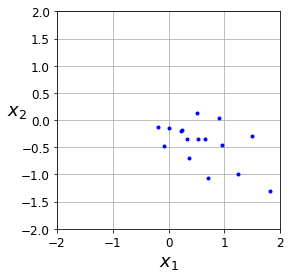

Training Bob in Epoch 1/5
Epoch: 1, Mi is 1.9086277484893799
Training Bob in Epoch 2/5
Epoch: 2, Mi is 1.8656436204910278
Training Bob in Epoch 3/5
Epoch: 3, Mi is 1.848978877067566
Training Bob in Epoch 4/5
Epoch: 4, Mi is 1.8430954217910767
Training Bob in Epoch 5/5
Epoch: 5, Mi is 1.8521058559417725


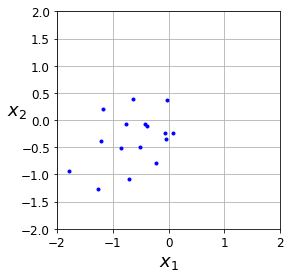

Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -1.84044, Batch_BER: 0.90600
Iteration: 20, Epoch: 1, Loss: -1.82914, Batch_BER: 0.89000
Iteration: 30, Epoch: 1, Loss: -1.81821, Batch_BER: 0.82000
Iteration: 40, Epoch: 1, Loss: -1.80762, Batch_BER: 0.78400
Iteration: 50, Epoch: 1, Loss: -1.79741, Batch_BER: 0.73800
Iteration: 60, Epoch: 1, Loss: -1.78759, Batch_BER: 0.67800
Iteration: 70, Epoch: 1, Loss: -1.77813, Batch_BER: 0.58800
Iteration: 80, Epoch: 1, Loss: -1.76902, Batch_BER: 0.57200
Iteration: 90, Epoch: 1, Loss: -1.76026, Batch_BER: 0.49200
Iteration: 100, Epoch: 1, Loss: -1.75180, Batch_BER: 0.45600
Iteration: 110, Epoch: 1, Loss: -1.74358, Batch_BER: 0.39600
Iteration: 120, Epoch: 1, Loss: -1.73562, Batch_BER: 0.41200
Iteration: 130, Epoch: 1, Loss: -1.72787, Batch_BER: 0.41000
Iteration: 140, Epoch: 1, Loss: -1.72035, Batch_BER: 0.36600
Iteration: 150, Epoch: 1, Loss: -1.71298, Batch_BER: 0.37400
Iteration: 160, Epoch: 1, Loss: -1.70580, Batch_BER: 0.32600
Iterati

Iteration: 130, Epoch: 4, Loss: 0.74663, Batch_BER: 0.29000
Iteration: 140, Epoch: 4, Loss: 0.74539, Batch_BER: 0.35400
Iteration: 150, Epoch: 4, Loss: 0.74640, Batch_BER: 0.28600
Iteration: 160, Epoch: 4, Loss: 0.74495, Batch_BER: 0.26000
Iteration: 170, Epoch: 4, Loss: 0.74506, Batch_BER: 0.28600
Iteration: 180, Epoch: 4, Loss: 0.74503, Batch_BER: 0.32000
Iteration: 190, Epoch: 4, Loss: 0.74500, Batch_BER: 0.31200
Iteration: 200, Epoch: 4, Loss: 0.74574, Batch_BER: 0.31400
Iteration: 210, Epoch: 4, Loss: 0.74563, Batch_BER: 0.30800
Iteration: 220, Epoch: 4, Loss: 0.74568, Batch_BER: 0.31600
Iteration: 230, Epoch: 4, Loss: 0.74486, Batch_BER: 0.26600
Iteration: 240, Epoch: 4, Loss: 0.74563, Batch_BER: 0.27800
Iteration: 250, Epoch: 4, Loss: 0.74539, Batch_BER: 0.29400
Iteration: 260, Epoch: 4, Loss: 0.74526, Batch_BER: 0.30800
Iteration: 270, Epoch: 4, Loss: 0.74527, Batch_BER: 0.28800
Iteration: 280, Epoch: 4, Loss: 0.74545, Batch_BER: 0.31200
Iteration: 290, Epoch: 4, Loss: 0.74549,

In [19]:
train_mi(n_epochs=1, n_steps=500, batch_size=128)
train_encoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.005)
test_encoding(M, 1)
train_encoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.0005)
test_encoding(M, 1)
train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.005, plot_encoding=False)

In [20]:
bber_data = Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


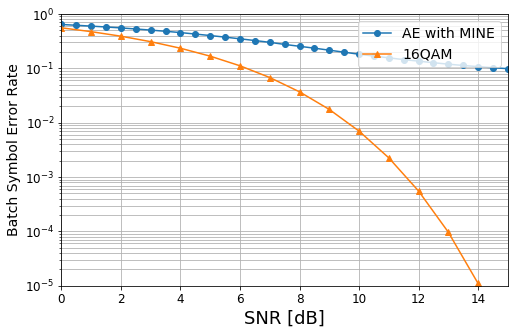

In [21]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data[0], bber_data[1], 'o-')

plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with MINE', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")